In [1]:
from neural_network.nn_manager.TrainManager import TrainManager
from neural_network.store.DBNNSave import DBNNSave
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input, Conv2D, BatchNormalization
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import keras
import keras.backend as K
from random import shuffle
import h5py
import numpy as np
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
np.random.seed(7)

Using TensorFlow backend.


In [7]:
class retinaNN(TrainManager):
    def __init__(self):
        self.path_to_data = './data_s5.hdf5'
        self.prepare_data(self.path_to_data)
        self.batch_size = 10
        self.epochs = 25
        self.example_images = []
        super(retinaNN, self).__init__()
        
        self.datagen_train = ImageDataGenerator(
            vertical_flip=True,
            horizontal_flip=True,
            zoom_range=0.2,
            shear_range=0.2,
            rotation_range = 30
        )
        
        self.datagen_val = ImageDataGenerator(
        )
        
    def prepare_data(self, path):
        hdf5_file = h5py.File(path, 'r')
        self.get_handlers(hdf5_file)
        self.load_sizes()
        
    def load_sizes(self):
        self.img_size_1 = self.X_train.shape[1]
        self.img_size_2 = self.X_train.shape[2]
        self.outputs_size = self.Y_train.shape[1]
        self.num_train_samples = self.X_train.shape[0]
        self.num_val_samples = self.X_val.shape[0]
        self.num_test_samples = self.X_test.shape[0]
    
    def get_handlers(self, file):
        self.X_train = file['train_data_x']
        self.X_train_medic = file['train_data_medic']
        self.Y_train = file['train_data_y']
        self.X_val = file['val_data_x']
        self.X_val_medic = file['val_data_medic']
        self.Y_val = file['val_data_y']
        self.X_test = file['test_data_x']
        self.Y_test = file['test_data_y']
        self.X_test_medic = file['test_data_medic']
    
    def store_method(self):
        return DBNNSave()

    def train_data_generator(self):
        generator = self._generator(self.X_train,  self.X_train_medic, self.Y_train, self.datagen_train)
        return generator

    def test_data_generator(self):
        generator = self._generator(self.X_val, self.X_train_medic, self.Y_val, self.datagen_val)
        return generator

    def create_model(self):
        input_image = Input(shape=(self.img_size_1, self.img_size_2, 3))
        input_med = Input(shape=(93,))

        layer = Conv2D(filters=32, kernel_size=(3, 3))(input_image)
        layer = BatchNormalization(axis=1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        
        layer = Conv2D(filters=32, kernel_size=(3, 3))(input_image)
        layer = BatchNormalization(axis=1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        
        layer = Flatten()(layer)
        
        merge = keras.layers.concatenate([layer, input_med])
        
        layer = Dense(self.outputs_size)(merge)
        layer = BatchNormalization(axis=1)(layer)
        output_layer = Activation('softmax')(layer)
        model = Model(inputs=[input_image,input_med], outputs=output_layer)
        model.compile( optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[self.f1_score, self.precision, self.recall])
        return model

    def f1_score(self, y_true, y_pred):
        c1 = self.get_true_positive(y_true,y_pred)
        c2 = self.get_positive_pred(y_pred)
        c3 = self.get_positive_true(y_true)

        if c3 == 0:
            return 0

        precision = c1 / c2
        recall = c1 / c3
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score
    
    def precision(self,y_true,y_pred):
        c1 = self.get_true_positive(y_true,y_pred)
        c2 = self.get_positive_pred(y_pred)
        return c1/c2
    
    def recall(self,y_true,y_pred):
        c1 = self.get_true_positive(y_true,y_pred)
        c3 = self.get_positive_true(y_true)
        return c1/c3
    
    def get_true_positive(self,y_true,y_pred):
        return K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    def get_positive_pred(self,y_pred):
        return K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    def get_positive_true(self,y_true):
        return K.sum(K.round(K.clip(y_true, 0, 1)))
    
    def _generator(self,X,X_medic,Y,datagen):       
        while 1:
            batch_s = self.batch_size
            for i in range(X.shape[0] // self.batch_size):
                x_part1 = X[i*batch_s: (i+1)*batch_s]
                x_part2 = X_medic[i*batch_s: (i+1)*batch_s]
                y_part = Y[i*batch_s: (i+1)*batch_s]
                yield [x_part1,x_part2], y_part
        
    def train(self):
        return self.train_model(
            self.num_train_samples // self.batch_size,
            self.num_val_samples // self.batch_size,
            epochs=self.epochs
        )

In [8]:
retina = retinaNN()
print(len(retina.X_train))
print(len(retina.X_val))
print(len(retina.X_test))


history = retina.train()

180
60
57
Epoch 1/25
18/18 [==============================] - 14s 759ms/step - loss: 0.1128 - f1_score: nan - precision: nan - recall: 0.0000e+00 - val_loss: 0.1322 - val_f1_score: nan - val_precision: nan - val_recall: 0.0000e+00
Epoch 2/25
18/18 [==============================] - 11s 601ms/step - loss: 0.0922 - f1_score: nan - precision: nan - recall: 0.0000e+00 - val_loss: 0.1134 - val_f1_score: nan - val_precision: nan - val_recall: 0.0000e+00
Epoch 3/25
18/18 [==============================] - 11s 598ms/step - loss: 0.0828 - f1_score: nan - precision: nan - recall: 0.0000e+00 - val_loss: 0.1085 - val_f1_score: nan - val_precision: nan - val_recall: 0.0000e+00
Epoch 4/25
18/18 [==============================] - 11s 605ms/step - loss: 0.0761 - f1_score: nan - precision: nan - recall: 0.0000e+00 - val_loss: 0.1070 - val_f1_score: nan - val_precision: nan - val_recall: 0.0000e+00
Epoch 5/25
18/18 [==============================] - 11s 597ms/step - loss: 0.0723 - f1_score: nan - precis

KeyError: 'val_loss'

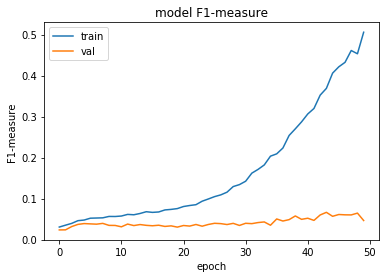

In [9]:
import matplotlib.pyplot as plt
# x = np.arange(50)
# plt.plot(x,history.history['precision'])
# plt.plot(x,history.history['val_precision'])
# #plt.plot(x,accf)
# #plt.plot(x,val_accf)
# plt.title('model precision')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.plot(history.history['recall'])
# plt.plot(history.history['val_recall'])
# #plt.plot(x,lossf)
# #plt.plot(x,val_lossf)
# plt.title('model recall')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
#plt.plot(x,lossf)
#plt.plot(x,val_lossf)
plt.title('model F1-measure')
plt.ylabel('F1-measure')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('f1.png')
plt.show()

In [9]:
from sklearn.metrics import roc_curve, auc

def change_y_to_words(y,index,y_t):
    hdf5_file = h5py.File(retina.path_to_data, 'r')
    n_gram = hdf5_file.attrs['n_gram']
    print(tuple(n_gram[index]))
    print(y)
    print(y_t)
    predicted_words = []
#     for i in range(len(y)):
#         if y[i] > 0.90:
#             #print(index)
#             predicted_words.append(tuple(n_gram[i]))
    return predicted_words

def get_model_quality(y_true,y_pred):
    c1 = sum(np.around(y_true*y_pred)) #TP
    c2 = sum(np.around(y_pred))
    c3 = sum(np.around(y_true))
    precision = c1/c2
    recall = c1 / c3
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

w = len(retina.Y_test[0])
h = retina.Y_test.shape[0]
pred_y = [[0 for i in range(h)] for j in range(w)]
true_y = [[0 for i in range(h)] for j in range(w)]
print(len(pred_y))
def test_model():
    for i in range(len(retina.X_test)):
        x_test = retina.X_test[i:i+1]
        x_test2 = retina.X_test_medic[i:i+1]
        y_test = retina.Y_test[i]
        y_score = retina.model.predict([x_test,x_test2])
        c = []
        for j in range(len(y_test)):
            true_y[j][i] = y_test[j]
            d =0 
            if y_score[0][j] > 0.5:
                c.append(1)
                d = 1
            else:
                d = 0
                c.append(0)
            pred_y[j][i] = y_score[0][j]

        precision, recall, f1_score = get_model_quality(y_test,y_score[0])
    
    aucs = []
    for i in range(len(pred_y)):
        roc_auc = generate_results(true_y[i],pred_y[i],i)
        aucs.append(roc_auc)
    
    print(np.nanmean(aucs))
test_model()

1000


C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


('obraz', 'af')
[0.0015284059, 0.00095213379, 0.0011568349, 0.0012679219, 0.0018305772, 0.0012892634, 0.00036176163, 0.00088529947, 0.00047969879, 0.0010362257, 0.0012700993, 0.0016114913, 0.002658356, 0.0005858182, 0.0071210074, 0.0020504368, 0.0023201185, 0.0021736126, 0.0011718679, 0.0012390445, 0.0028608006, 0.0020574182, 0.00085474056, 0.0013347002, 0.0012474392, 0.0017630988, 0.0016411062, 0.0017903114, 0.011506232, 0.0011362978, 0.003275539, 0.0020785662, 0.0011402076, 0.0012889192, 0.0022184902, 0.001451392, 0.0029212811, 0.0013703398, 0.0015917869, 0.00059577532, 0.00078359508, 0.001188971, 0.001232125, 0.0021453546, 0.0035711166, 0.00038130485, 0.0013135218, 0.00063573569, 0.0018676926, 0.0016145537, 0.0011215832, 0.00045838297, 0.0014545608, 0.00076854834, 0.0018867635, 0.0018776059, 0.00066577527]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
('wskaz

('błona', 'neowaskularna')
[0.00092572102, 0.00093387457, 0.00048841559, 0.0012649696, 0.00076660165, 0.0006705352, 0.00086389249, 0.00086667557, 0.00077156979, 0.00092533737, 0.0010753917, 0.00099508173, 0.00079028762, 0.00098327, 0.00098748168, 0.0008119499, 0.00078875042, 0.0012212156, 0.0010011228, 0.00076354283, 0.00086124224, 0.0015123745, 0.001176944, 0.00093911489, 0.00099621643, 0.0007514137, 0.00079002004, 0.00084922009, 0.0017341472, 0.0010316891, 0.0010088068, 0.00088213029, 0.0012724504, 0.00098573416, 0.00062194245, 0.0010330629, 0.00098592159, 0.0012092728, 0.0012548716, 0.00094902399, 0.00045251712, 0.0013348489, 0.00055375276, 0.0010670989, 0.00064105773, 0.0008260574, 0.00085486058, 0.00096450804, 0.00073060236, 0.0014239689, 0.0010314245, 0.00066318305, 0.0012529269, 0.0012754002, 0.00066403334, 0.00080276682, 0.0009833643]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

('przebieg', 'wysiękowy')
[0.00052790245, 0.00079761294, 0.00055606355, 0.00082351372, 0.0006001463, 0.00046861431, 0.000937782, 0.001046379, 0.0011218777, 0.0010569936, 0.00084879267, 0.0007821591, 0.00076324417, 0.00087257527, 0.00048156132, 0.0009011635, 0.00073353783, 0.00061862444, 0.00076530833, 0.0011943526, 0.00076817197, 0.00077321951, 0.0008821435, 0.00089942868, 0.00083059369, 0.0005307055, 0.0009611962, 0.00083162659, 0.00059725222, 0.00048147741, 0.00074393768, 0.00070733967, 0.00089012343, 0.0011321624, 0.00069471536, 0.00079389353, 0.00059466023, 0.00084325537, 0.00087739545, 0.00070506311, 0.00047029246, 0.00077967637, 0.00095505023, 0.00078057661, 0.00092269521, 0.0010904752, 0.00057257945, 0.0012482564, 0.00090934528, 0.00082281063, 0.00064221077, 0.00045852741, 0.00069329649, 0.0013973549, 0.00084645645, 0.0006575961, 0.00049211469]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def generate_results(y_test, y_score, i, plot=False):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    if roc_auc > 0.9:
        #print('AUC: %f' % roc_auc)
        change_y_to_words(y_score,i,y_test)
        #plot = True
    if plot:
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.show()
    return roc_auc


In [10]:
f = h5py.File('./data_s100.hdf5', 'r')
for k, v in f['test_data_metadata/27'].items():
    print(k,v.value)

KeyError: 'Unable to open object (component not found)'

In [16]:
import PIL
from text_processing.NGramCounter import NGramCounter
from text_processing.NGramVectorBuilder import NGramVectorBuilder
from data_module.models import Image as Retina_Image
from data_module.models import Person, Examination, Description, ImageSeries, ProcessedDescription
def get_ngram_vector_builder():
    n = 2; outputs = 1000; limit = 0
    ngc = NGramCounter()
    n_gram = ngc.get_n_gram_histogram(n,limit,outputs)
    return NGramVectorBuilder(n_gram), n_gram

i = Retina_Image.objects.get(id=2092)
img = PIL.Image.open(i.image)
#img.show()

desc = ProcessedDescription.objects.get(id=7)
print(desc.text)
iss = ImageSeries.objects.get(id=6)
e = iss.examination
print(e.person.code_name)
nGramVbuild,n_gram = get_ngram_vector_builder()
words_vector = nGramVbuild.get_vector(290, 'R')
#print(words_vector)
#print(n_gram)
n_gram = list(dict(n_gram))
#print(n_gram)
for i in range(len(words_vector)):
    if(words_vector[i] == 1):
        print(n_gram[i])
#print(n_gram)




ukazować faza mieszany ognisko hipofluorescencja odpowiadać wybroczyna krwotoczki ognisko hiperfluorescencja odpowiadać mikroaneuryzmaty faza późny obrzęk siatkówka masywny wzdłuż arkada torbielowaty dochodzić plamka obwód początkowy zmiana naczyniowy tworzyć strefa awaskularne
D_00e72bbf43229b7e7eed9816f658f20c


In [11]:
for i in range(0,10):
    w = f['train_data_metadata/'+str(i)+'/series'].value
    s = f['train_data_metadata/'+str(i)+'/side'].value      
    words_vector = nGramVbuild.get_vector(w, s)
    for j in range(len(words_vector)):
        if(words_vector[j] == 1):
            print(n_gram[j],i)
            
print(f['train_data_metadata/1/series'].value)

KeyError: 'Unable to open object (component not found)'

In [21]:
i = Retina_Image.objects.get(id=4379)
img = PIL.Image.open(i.image)
img.save('i3.png')

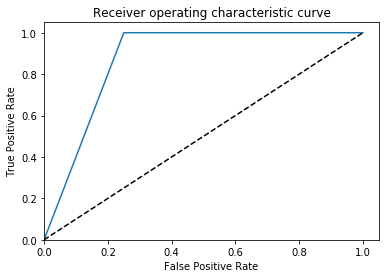

0.875

In [17]:
ys = [0.8, 0.7,   0.6, 0.4, 0.8]
yt = [1,   0,   0,   0,   0]
generate_results(yt, ys, 0, plot=True)